In [1]:
import gym
import numpy as np
import os
from offsim4rl.data import OfflineDataset, ProbDistribution
from offsim4rl.evaluators.per_state_rejection import PerStateRejectionSampling
from offsim4rl.evaluators.trivial_baselines import FollowObservationOnly, FollowActionOnly, ServeRandomTransitions
from offsim4rl.agents import spinup
import torch

No protocol specified


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
from offsim4rl.utils.dataset_utils import load_h5_dataset
buffer = load_h5_dataset('../outputs/MyGridNaviCoords-v1_random.h5')

load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 34.31it/s]


In [5]:
import argparse
parser = argparse.ArgumentParser()
args = parser.parse_args([])
args.seed = 0
args.latent_size = 50
args.hidden_size = 64
args.lr = 0.001
args.weight_decay = 0.0

category = 'both'
trial = '20220811T1457'
args.output_dir = "../../wip/output/" + f"./trial={trial},encoder_model={category},seed={args.seed}," + \
        f"dZ={args.latent_size},dH={args.hidden_size},lr={args.lr},weight_decay={args.weight_decay}/"

In [6]:
from offsim4rl.encoders.homer import HOMEREncoder
homer_encoder = HOMEREncoder(
    obs_dim=2, action_dim=5,
    latent_size=args.latent_size,
    hidden_size=args.hidden_size,
    model_path=os.path.join(args.output_dir, 'encoder_model.pt'),
    log_dir=os.path.join(args.output_dir, 'logs'),
)

/home/t-stang/microsoft/rl-offline-simulation/offsim4rl/encoders/homer.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  observations = torch.tensor(observations, dtype=torch.float, device=self.device)


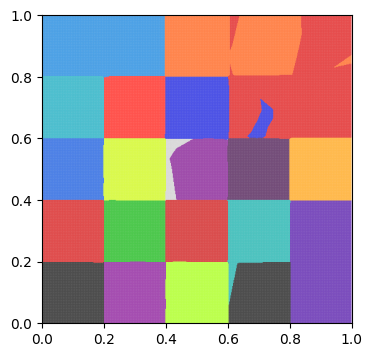

In [7]:
from offsim4rl.utils.vis_utils import plot_latent_state_color_map
x, y = np.meshgrid(np.arange(0, 1, 0.002), np.arange(0, 1, 0.002))
obs = torch.tensor(np.stack([x, y]).reshape((2, -1)).T, dtype=torch.float, device=homer_encoder.device)
emb = homer_encoder.encode(obs)
df_output = pd.DataFrame([(i, *x) for i, x in zip(emb, obs)], columns=['i', 'x', 'y'])
plot_latent_state_color_map(df_output, os.path.join('/tmp/latent_state.png'))

In [7]:
dataset = OfflineDataset(
    observation_space=gym.spaces.Box(low=0, high=1, shape=(2,)),
    action_space=gym.spaces.Discrete(5),
    action_dist_type=ProbDistribution.Discrete,
    observations=buffer['observations'],
    actions=buffer['actions'].astype(int),
    action_distributions=buffer['infos/probs'],
    rewards=buffer['rewards'],
    next_observations=buffer['next_observations'],
    terminals=buffer['terminals'].astype(bool),
    steps=buffer['infos/steps'].astype(int),
)

2022-08-25 16:09:57,690 - WARNING - root -  Missing episode_ids in experience. Some algorithms may not be compatible with this dataset.


In [8]:
psrs = FollowObservationOnly(
    dataset,
    num_states=50,
    encoder=homer_encoder,
)

In [9]:
# true env for online validation
env = gym.make('MyGridNaviCoords-v1', seed=100000)
env.reset_task(np.array([4, 4]))

array([4, 4])

In [ ]:
for seed in range(10):
    psrs.reset_sampler(seed=seed)
    spinup.ppo_revealed(
        env_fn=lambda: psrs, steps_per_epoch=5000, epochs=50, seed=seed, 
        logger_kwargs=dict(output_dir=f'./outputs/grid_psrs_baseline-obs-only/seed={seed}', exp_name='MyGridNaviCoords-v1_ppo'), 
        ac_kwargs=dict(hidden_sizes=[32, 32], activation=torch.nn.ReLU), 
        validate=True, val_kwargs=dict(val_env_fn=lambda: env, val_n_episodes=10))

Logging data to ./outputs/grid_psrs_baseline-obs-only/seed=0/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "activation":	"ReLU",
        "hidden_sizes":	[
            32,
            32
        ]
    },
    "actor_critic":	"MLPActorCritic_Revealed",
    "clip_ratio":	0.2,
    "env_fn":	"<function <lambda> at 0x7fe9d71d5290>",
    "epochs":	50,
    "exp_name":	"MyGridNaviCoords-v1_ppo",
    "gamma":	0.99,
    "lam":	0.97,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7fe9d72076d0>":	{
            "epoch_dict":	{},
            "exp_name":	"MyGridNaviCoords-v1_ppo",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"./outputs/grid_psrs_baseline-obs-only/seed=0",
            "output_file":	{
                "<_io.TextIOWrapper name='./outputs/grid_psrs_baseline-obs-only/seed=0/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"
                }
            }


In [11]:
dfs = [pd.read_csv(f'./outputs/grid_psrs_baseline-obs-only/seed={seed}/progress.txt', sep='\t') for seed in range(10)]

In [12]:
df = pd.read_csv('./outputs/grid_psrs_baseline-obs-only/seed=0/progress.txt', sep='\t')

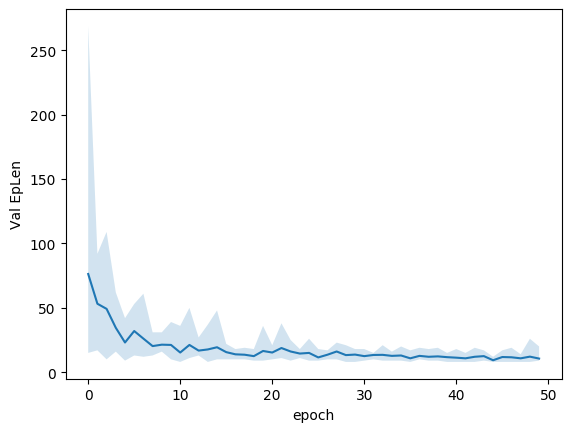

In [13]:
plt.plot(df['AverageVal_EpLen'])
plt.fill_between(df['Epoch'], df['MinVal_EpLen'], df['MaxVal_EpLen'], alpha=0.2)
plt.xlabel('epoch')
plt.ylabel('Val EpLen')
plt.show()

In [14]:
dfs_ = [pd.read_csv(f'./outputs/grid_true/seed={seed}/progress.txt', sep='\t') for seed in range(10)]
df_ = pd.concat(dfs_).groupby('Epoch').mean().reset_index()

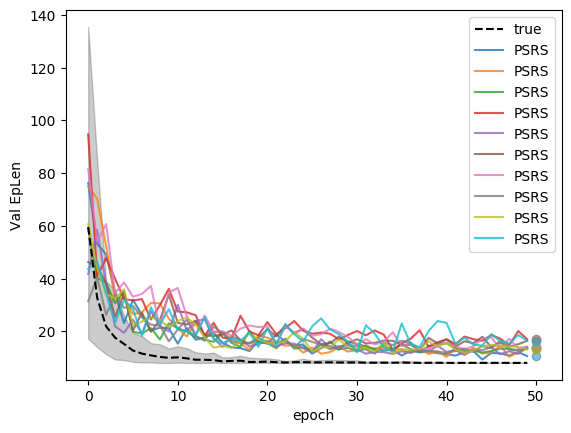

In [15]:
plt.plot(df_['AverageVal_EpLen'], color='k', ls='--', label='true', zorder=10)
plt.fill_between(df_['Epoch'], df_['MinVal_EpLen'], df_['MaxVal_EpLen'], alpha=0.2, color='k')
for df in dfs:
    plt.plot(df['AverageVal_EpLen'], lw=1.5, alpha=0.8, label='PSRS')
    plt.scatter(len(df['AverageVal_EpLen']), df['AverageVal_EpLen'].iloc[-1], marker='o', color=plt.gca().lines[-1].get_color(), alpha=0.5, zorder=11)
plt.xlabel('epoch')
plt.ylabel('Val EpLen')
plt.legend()
plt.show()

In [16]:
from spinup.utils.test_policy import load_policy_and_env, run_policy
_, get_action = load_policy_and_env(f'./outputs/grid_psrs_baseline-obs-only/seed={1}')
run_policy(env, lambda x: int(get_action(x).sample()), render=False, num_episodes=10)



Loading from ./outputs/grid_psrs_baseline-obs-only/seed=1/pyt_save/model.pt.


Logging data to /tmp/experiments/1661446733/progress.txt
Episode 0 	 EpRet 0.000 	 EpLen 11
Episode 1 	 EpRet -0.100 	 EpLen 12
Episode 2 	 EpRet 0.300 	 EpLen 8
Episode 3 	 EpRet 0.300 	 EpLen 8
Episode 4 	 EpRet -0.100 	 EpLen 12
Episode 5 	 EpRet -0.200 	 EpLen 13
Episode 6 	 EpRet -0.300 	 EpLen 14
Episode 7 	 EpRet 0.100 	 EpLen 10
Episode 8 	 EpRet -0.700 	 EpLen 18
Episode 9 	 EpRet -0.300 	 EpLen 14
-------------------------------------
|    AverageEpRet |            -0.1 |
|        StdEpRet |           0.286 |
|        MaxEpRet |             0.3 |
|        MinEpRet |            -0.7 |
|           EpLen |              12 |
-------------------------------------


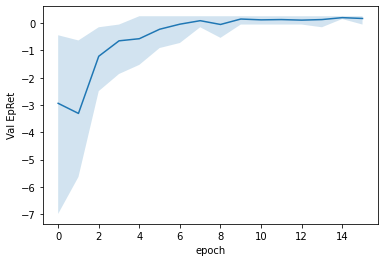

In [14]:
plt.plot(df['AverageVal_EpRet'])
plt.fill_between(df['Epoch'], df['MinVal_EpRet'], df['MaxVal_EpRet'], alpha=0.2)
plt.xlabel('epoch')
plt.ylabel('Val EpRet')
plt.show()

In [ ]:
def test_per_state_rejection_discrete():
    dataset = OfflineDataset(
        observation_space=gym.spaces.Discrete(25),
        action_space=gym.spaces.Discrete(4),
        action_dist_type=ProbDistribution.Discrete,
        observations=np.array([0, 5], dtype=np.int64),
        actions=np.array([0, 1], dtype=np.int64),
        action_distributions=np.full((2, 4), fill_value=0.25, dtype=np.float32),
        rewards=np.array([0.0, 1.0], dtype=np.float32),
        next_observations=np.array([5, 7], dtype=np.int64),
        terminals=np.array([False, True], dtype=bool))
    psrs = PerStateRejectionSampling(dataset)
    obs = psrs.reset()
    assert obs.shape == tuple()
    psrs.step_dist(get_uniform_dist(dataset.action_space))

In [1]:
import sys
sys.path.append('../../src')

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
import HOMER.data
buffer = HOMER.data.load_h5_dataset('../../data/grid/MyGridNaviCoords-v1_random.hdf')

load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 37.16it/s]


In [4]:
buffer.keys()

dict_keys(['actions', 'infos/probs', 'infos/timesteps', 'next_observations', 'observations', 'rewards', 'terminals'])

In [5]:
buffer_ = [(
    buffer['observations'][i],
    buffer['actions'][i],
    buffer['rewards'][i],
    buffer['next_observations'][i],
    buffer['terminals'][i],
    buffer['infos/probs'][i],
    {'t': buffer['infos/timesteps'][i]},
) for i in range(len(buffer['observations']))]

In [6]:
buffer_[0]

(array([0.04276233, 0.12755609], dtype=float32),
 3,
 -0.1,
 array([0.18468815, 0.01150152], dtype=float32),
 False,
 array([0.2, 0.2, 0.2, 0.2, 0.2], dtype=float32),
 {'t': 0.0})

In [7]:
from HOMER.model import EncoderModel
encoding_function = EncoderModel(2, 5, 50, 64).to(device)
encoding_function.load('./HOMER/output/trial=20220727T1748,encoder_model=both,seed=0,dZ=50,dH=64,lr=0.001,weight_decay=0.0/', 'encoder_model.pt')

import torch.nn.functional as F
def encode_observations(model, observations):
    assert len(observations.size()) == 1
    observations = observations.view(1, -1)
    log_prob = F.log_softmax(model.obs_encoder(observations), dim=1)
    argmax_indices = log_prob.max(1)[1]
    return int(argmax_indices[0])

In [8]:
import simulate.lib_psrs
import gym

In [9]:
env_psrs = simulate.lib_psrs.gymPSRS(
    buffer_,
    observation_space=gym.spaces.Box(low=0, high=1, shape=(2,)), 
    action_space=gym.spaces.Discrete(5), 
    latent_state_func=lambda s: encode_observations(encoding_function, torch.tensor(s).to(device))
)

In [10]:
env_psrs.reset_sampler(seed=0)

In [11]:
env_psrs.buffer

[(44,
  array([0.04276233, 0.12755609], dtype=float32),
  3,
  -0.1,
  array([0.18468815, 0.01150152], dtype=float32),
  False,
  array([0.2, 0.2, 0.2, 0.2, 0.2], dtype=float32),
  {'t': 0.0}),
 (44,
  array([0.18468815, 0.01150152], dtype=float32),
  1,
  -0.1,
  array([0.13923521, 0.2853215 ], dtype=float32),
  False,
  array([0.2, 0.2, 0.2, 0.2, 0.2], dtype=float32),
  {'t': 1.0}),
 (15,
  array([0.13923521, 0.2853215 ], dtype=float32),
  0,
  -0.1,
  array([0.0665991 , 0.33859718], dtype=float32),
  False,
  array([0.2, 0.2, 0.2, 0.2, 0.2], dtype=float32),
  {'t': 2.0}),
 (15,
  array([0.0665991 , 0.33859718], dtype=float32),
  0,
  -0.1,
  array([0.11653665, 0.23789696], dtype=float32),
  False,
  array([0.2, 0.2, 0.2, 0.2, 0.2], dtype=float32),
  {'t': 3.0}),
 (15,
  array([0.11653665, 0.23789696], dtype=float32),
  4,
  -0.1,
  array([0.05105221, 0.21079233], dtype=float32),
  False,
  array([0.2, 0.2, 0.2, 0.2, 0.2], dtype=float32),
  {'t': 4.0}),
 (15,
  array([0.05105221, 0.2

In [13]:
import spinup
env_fn = lambda: env_psrs
ac_kwargs = dict(hidden_sizes=[32,32], activation=torch.nn.ReLU)
logger_kwargs = dict(output_dir='../../data/grid/psrs3', exp_name='MyGridNaviCoords-v1_ppo_test_psrs3')

In [14]:
spinup.algos.pytorch.ppo_revealed.ppo.ppo(env_fn=env_fn, ac_kwargs=ac_kwargs, steps_per_epoch=5000, epochs=50, logger_kwargs=logger_kwargs)

Logging data to ../../data/grid/psrs3/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "activation":	"ReLU",
        "hidden_sizes":	[
            32,
            32
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "clip_ratio":	0.2,
    "env_fn":	"<function <lambda> at 0x7ff3e5c144c0>",
    "epochs":	50,
    "exp_name":	"MyGridNaviCoords-v1_ppo_test_psrs3",
    "gamma":	0.99,
    "lam":	0.97,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7ff34f597dc0>":	{
            "epoch_dict":	{},
            "exp_name":	"MyGridNaviCoords-v1_ppo_test_psrs3",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"../../data/grid/psrs3",
            "output_file":	{
                "<_io.TextIOWrapper name='../../data/grid/psrs3/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"
                }
            }
        }
    },
    "logger_kwargs":	{
        "exp_nam

In [ ]:
import importlib
importlib.reload(simulate.lib_psrs)
importlib.reload(spinup)

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
df = pd.read_csv('../../data/grid/psrs3/progress.txt', sep='\t')

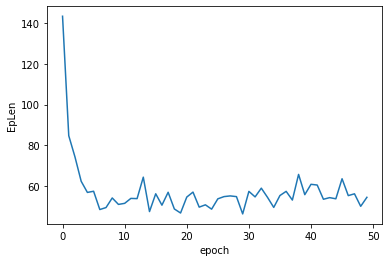

In [17]:
plt.plot(df['EpLen'])
plt.xlabel('epoch')
plt.ylabel('EpLen')
plt.show()

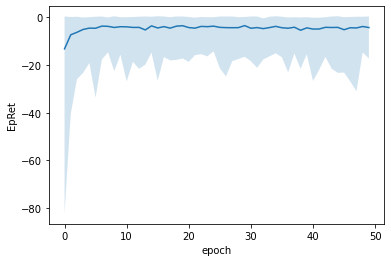

In [18]:
plt.plot(df['AverageEpRet'])
plt.fill_between(df['Epoch'], df['MinEpRet'], df['MaxEpRet'], alpha=0.2)
plt.xlabel('epoch')
plt.ylabel('EpRet')
plt.show()